# Dam Break Simulation with Boundary Conditions

This notebook demonstrates a classic SPH validation test: the **dam break problem**.

A column of fluid is released and collapses under pressure gradients, interacting with solid boundaries.

## Physics
- Pressure-driven flow using SPH
- Reflective boundary conditions (walls)
- No gravity (pure pressure dynamics)

In [12]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.units as u
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
import sys

# Force fresh import of gravhydro
modules_to_remove = [key for key in sys.modules.keys() if 'gravhydro' in key]
for mod in modules_to_remove:
    del sys.modules[mod]

import gravhydro as gh
from gravhydro.utils.units import convert_to_internal, L_UNIT, M_UNIT, t_UNIT

## Setup Parameters

We use galactic units (gravhydro's internal system) scaled appropriately.

In [13]:
# ============== SIMULATION PARAMETERS ==============
# Smoothing length (in internal units where 1 unit = 100 pc)
h = 0.3  # internal units

# Sound speed
cs = 100 * u.km / u.s

# Time settings
t_end = 30  # Myr
n_steps = 100
ts = np.linspace(0, t_end, n_steps + 1) * u.Myr

# Domain boundaries (in internal units)
x_min, x_max = 0.0, 4.0
y_min, y_max = 0.0, 3.0

print(f"Domain: [{x_min}, {x_max}] x [{y_min}, {y_max}] internal units")
print(f"       = [{x_min*100}, {x_max*100}] x [{y_min*100}, {y_max*100}] pc")
print(f"Smoothing length h = {h} internal = {h*100} pc")
print(f"Kernel support 2h = {2*h} internal = {2*h*100} pc")

Domain: [0.0, 4.0] x [0.0, 3.0] internal units
       = [0.0, 400.0] x [0.0, 300.0] pc
Smoothing length h = 0.3 internal = 30.0 pc
Kernel support 2h = 0.6 internal = 60.0 pc


In [14]:
# ============== CREATE FLUID PARTICLES (DAM) ==============
# Particle spacing
spacing = h / 2  # ~4 neighbors per smoothing length

# Dam dimensions (tall column on the left side)
dam_width = 1.0   # internal units
dam_height = 2.5  # internal units

# Create fluid particles
x_fluid = np.arange(spacing/2, dam_width, spacing)
y_fluid = np.arange(spacing/2, dam_height, spacing)
xx_f, yy_f = np.meshgrid(x_fluid, y_fluid)

fluid_pos_2d = np.column_stack([xx_f.ravel(), yy_f.ravel()])
n_fluid = len(fluid_pos_2d)

print(f"Fluid particles: {n_fluid}")
print(f"Dam size: {dam_width*100} pc x {dam_height*100} pc")

Fluid particles: 119
Dam size: 100.0 pc x 250.0 pc


In [15]:
# ============== CREATE BOUNDARY PARTICLES ==============
# We create "ghost" particles along the walls that don't move
# but contribute to density calculations

boundary_spacing = spacing
n_layers = 3  # Number of boundary particle layers

boundary_particles = []

# Bottom wall (y = 0)
for layer in range(n_layers):
    y_wall = -boundary_spacing * (layer + 0.5)
    x_wall = np.arange(spacing/2, x_max, boundary_spacing)
    for x in x_wall:
        boundary_particles.append([x, y_wall])

# Left wall (x = 0)
for layer in range(n_layers):
    x_wall = -boundary_spacing * (layer + 0.5)
    y_wall = np.arange(spacing/2, y_max, boundary_spacing)
    for y in y_wall:
        boundary_particles.append([x_wall, y])

# Right wall (x = x_max)
for layer in range(n_layers):
    x_wall = x_max + boundary_spacing * (layer + 0.5)
    y_wall = np.arange(spacing/2, y_max, boundary_spacing)
    for y in y_wall:
        boundary_particles.append([x_wall, y])

boundary_pos_2d = np.array(boundary_particles)
n_boundary = len(boundary_pos_2d)

print(f"Boundary particles: {n_boundary}")

Boundary particles: 201


In [16]:
# ============== COMBINE ALL PARTICLES ==============
# Fluid particles first, then boundary particles
all_pos_2d = np.vstack([fluid_pos_2d, boundary_pos_2d])

# Convert to 3D (add z=0)
pos = np.zeros((len(all_pos_2d), 3))
pos[:, :2] = all_pos_2d

# Velocities (all zero initially)
vel = np.zeros_like(pos)

# Masses - same for fluid and boundary
mass_value = 0.01  # internal mass units
masses = np.ones(len(pos)) * mass_value

# Track which particles are fluid vs boundary
is_fluid = np.zeros(len(pos), dtype=bool)
is_fluid[:n_fluid] = True

print(f"Total particles: {len(pos)} ({n_fluid} fluid + {n_boundary} boundary)")

Total particles: 320 (119 fluid + 201 boundary)


Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.


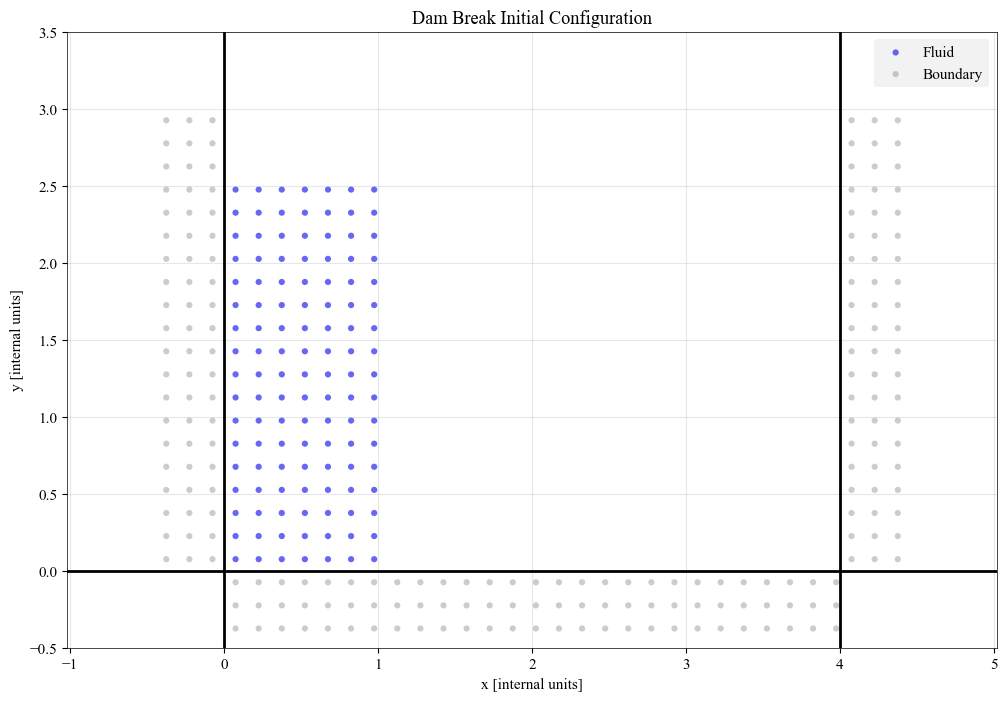

In [17]:
# Visualize initial setup
plt.figure(figsize=(12, 8))
plt.scatter(pos[is_fluid, 0], pos[is_fluid, 1], s=20, c='blue', alpha=0.6, label='Fluid')
plt.scatter(pos[~is_fluid, 0], pos[~is_fluid, 1], s=20, c='gray', alpha=0.4, label='Boundary')

# Draw domain boundaries
plt.axhline(y=0, color='k', linewidth=2)
plt.axvline(x=0, color='k', linewidth=2)
plt.axvline(x=x_max, color='k', linewidth=2)

plt.xlabel('x [internal units]')
plt.ylabel('y [internal units]')
plt.title('Dam Break Initial Configuration')
plt.legend()
plt.axis('equal')
plt.xlim(-0.5, x_max + 0.5)
plt.ylim(-0.5, y_max + 0.5)
plt.grid(True, alpha=0.3)
plt.show()

## Custom Simulation with Boundary Conditions

Since gravhydro doesn't have built-in boundary handling, we'll implement a custom time-stepping loop that:
1. Computes forces on all particles (including boundary contributions to density)
2. Only updates fluid particle positions
3. Applies reflective boundary conditions

In [18]:
from gravhydro.hydro.acceleration import pressureAcc
from gravhydro.hydro.density import densities
from tqdm import tqdm

def apply_boundaries(pos, vel, x_min, x_max, y_min):
    """
    Apply reflective boundary conditions.
    Particles that cross boundaries are reflected back.
    """
    # Left wall
    mask = pos[:, 0] < x_min
    pos[mask, 0] = 2*x_min - pos[mask, 0]
    vel[mask, 0] = -vel[mask, 0]
    
    # Right wall
    mask = pos[:, 0] > x_max
    pos[mask, 0] = 2*x_max - pos[mask, 0]
    vel[mask, 0] = -vel[mask, 0]
    
    # Bottom wall
    mask = pos[:, 1] < y_min
    pos[mask, 1] = 2*y_min - pos[mask, 1]
    vel[mask, 1] = -vel[mask, 1]
    
    return pos, vel

def run_dam_break(pos_init, vel_init, masses, is_fluid, ts, h, cs, 
                  x_min, x_max, y_min):
    """
    Run dam break simulation with boundary conditions.
    Only fluid particles move; boundary particles stay fixed.
    """
    n_steps = len(ts) - 1
    n_particles = len(pos_init)
    
    # Storage for trajectories (fluid particles only)
    n_fluid = is_fluid.sum()
    positions = np.zeros((len(ts), n_fluid, 3))
    velocities = np.zeros((len(ts), n_fluid, 3))
    
    # Current state (all particles)
    pos = pos_init.copy()
    vel = vel_init.copy()
    
    # Convert sound speed to internal units
    cs_internal = convert_to_internal(cs)
    
    # Calculate reference density from initial configuration
    dens_init = densities(pos, masses, h)
    rho0 = np.mean(dens_init[is_fluid])
    
    # Store initial state
    positions[0] = pos[is_fluid]
    velocities[0] = vel[is_fluid]
    
    dt = (ts[1] - ts[0]).value * convert_to_internal(1*u.Myr)
    
    for i in tqdm(range(n_steps)):
        # Half-step position update (fluid only)
        pos[is_fluid] += vel[is_fluid] * dt / 2
        
        # Compute acceleration using ALL particles (fluid + boundary)
        acc = pressureAcc(pos, masses, h, rho0, cs_internal)
        
        # Update velocity (fluid only)
        vel[is_fluid] += acc[is_fluid] * dt
        
        # Full-step position update (fluid only)
        pos[is_fluid] += vel[is_fluid] * dt / 2
        
        # Apply boundary conditions to fluid particles
        fluid_pos = pos[is_fluid]
        fluid_vel = vel[is_fluid]
        fluid_pos, fluid_vel = apply_boundaries(fluid_pos, fluid_vel, x_min, x_max, y_min)
        pos[is_fluid] = fluid_pos
        vel[is_fluid] = fluid_vel
        
        # Store state
        positions[i+1] = pos[is_fluid]
        velocities[i+1] = vel[is_fluid]
    
    return positions, velocities

In [19]:
# Run the simulation!
print("Running dam break simulation...")
positions, velocities = run_dam_break(
    pos, vel, masses, is_fluid, ts, h, cs,
    x_min=0, x_max=x_max, y_min=0
)
print("Done!")

Running dam break simulation...


  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [00:02<00:00, 39.77it/s]

Done!


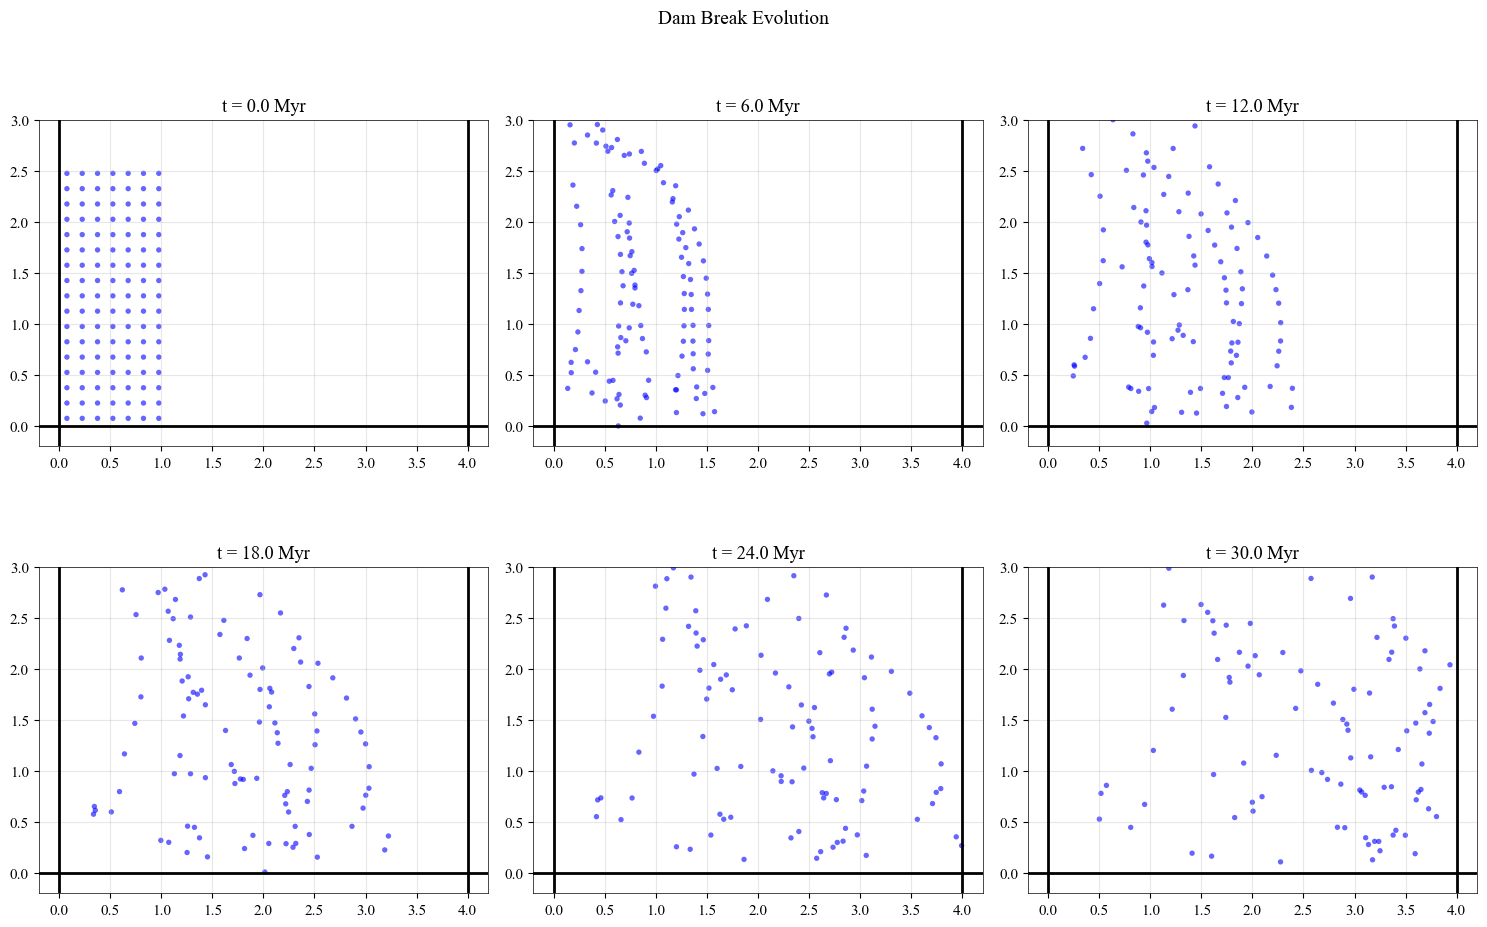

In [20]:
# ============== VISUALIZE RESULTS ==============
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

time_indices = [0, n_steps//5, 2*n_steps//5, 3*n_steps//5, 4*n_steps//5, n_steps]

for ax, idx in zip(axes.flat, time_indices):
    ax.scatter(positions[idx, :, 0], positions[idx, :, 1], s=15, c='blue', alpha=0.6)
    
    # Draw boundaries
    ax.axhline(y=0, color='k', linewidth=2)
    ax.axvline(x=0, color='k', linewidth=2)
    ax.axvline(x=x_max, color='k', linewidth=2)
    
    ax.set_xlim(-0.2, x_max + 0.2)
    ax.set_ylim(-0.2, y_max)
    ax.set_aspect('equal')
    ax.set_title(f't = {ts[idx].value:.1f} Myr')
    ax.grid(True, alpha=0.3)

plt.suptitle('Dam Break Evolution', fontsize=14)
plt.tight_layout()
plt.show()

In [21]:
# ============== ANIMATION ==============
fig, ax = plt.subplots(figsize=(10, 6))

scatter = ax.scatter([], [], s=20, c='blue', alpha=0.6)
time_text = ax.text(0.02, 0.95, '', transform=ax.transAxes, fontsize=12)

# Draw boundaries
ax.axhline(y=0, color='k', linewidth=2)
ax.axvline(x=0, color='k', linewidth=2)
ax.axvline(x=x_max, color='k', linewidth=2)

ax.set_xlim(-0.2, x_max + 0.2)
ax.set_ylim(-0.2, y_max)
ax.set_aspect('equal')
ax.set_xlabel('x [internal units]')
ax.set_ylabel('y [internal units]')
ax.set_title('Dam Break Simulation')
ax.grid(True, alpha=0.3)

def init():
    scatter.set_offsets(np.empty((0, 2)))
    time_text.set_text('')
    return scatter, time_text

def animate(frame):
    i = frame * max(1, len(ts) // 50)
    if i >= len(ts):
        i = len(ts) - 1
    
    offsets = np.column_stack([positions[i, :, 0], positions[i, :, 1]])
    scatter.set_offsets(offsets)
    time_text.set_text(f't = {ts[i].value:.1f} Myr')
    return scatter, time_text

anim = FuncAnimation(fig, animate, init_func=init, frames=50, interval=100, blit=True)
plt.close()
HTML(anim.to_jshtml())

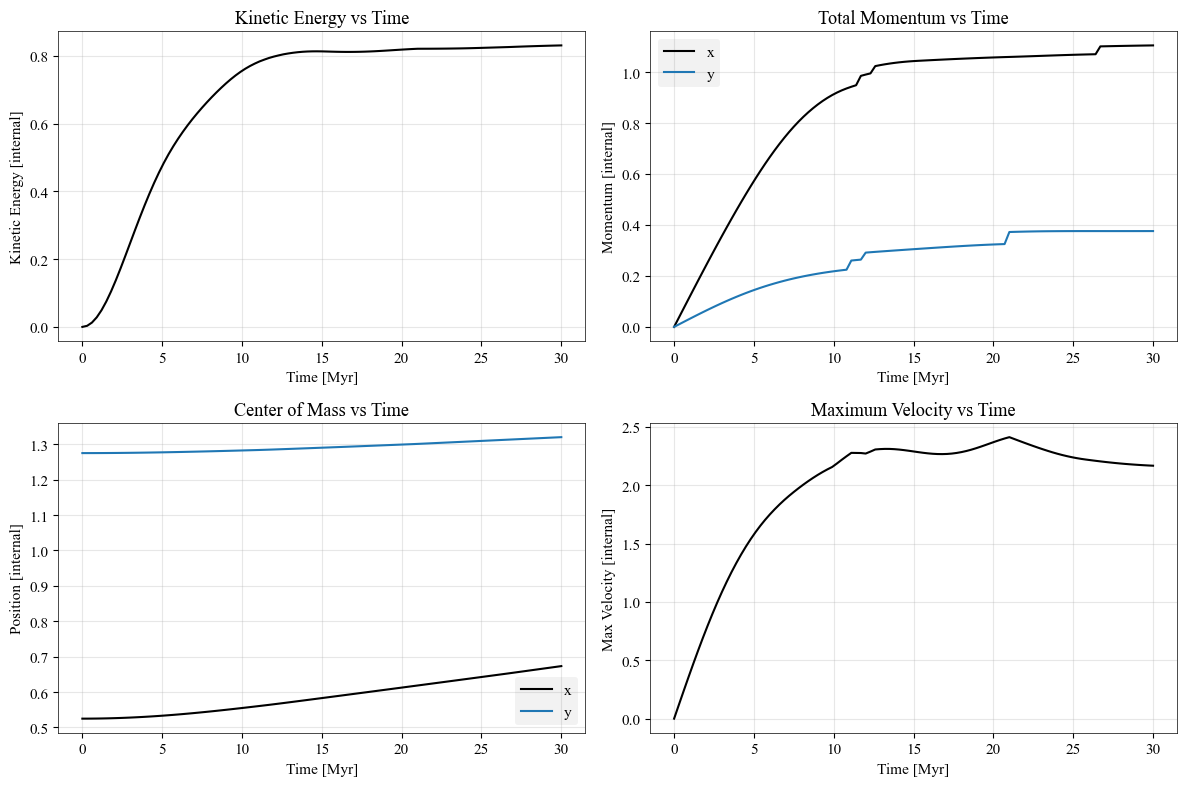

In [11]:
# ============== ANALYSIS: Energy and Momentum ==============
# Calculate kinetic energy and momentum over time

# Kinetic energy: 0.5 * m * v^2
v_squared = np.sum(velocities**2, axis=2)  # shape: (n_steps, n_fluid)
KE = 0.5 * mass_value * np.sum(v_squared, axis=1)  # shape: (n_steps,)

# Momentum: m * v
momentum_x = mass_value * np.sum(velocities[:, :, 0], axis=1)
momentum_y = mass_value * np.sum(velocities[:, :, 1], axis=1)

# Center of mass position
com_x = np.mean(positions[:, :, 0], axis=1)
com_y = np.mean(positions[:, :, 1], axis=1)

fig, axes = plt.subplots(2, 2, figsize=(12, 8))

axes[0, 0].plot(ts.value, KE)
axes[0, 0].set_xlabel('Time [Myr]')
axes[0, 0].set_ylabel('Kinetic Energy [internal]')
axes[0, 0].set_title('Kinetic Energy vs Time')
axes[0, 0].grid(True, alpha=0.3)

axes[0, 1].plot(ts.value, momentum_x, label='x')
axes[0, 1].plot(ts.value, momentum_y, label='y')
axes[0, 1].set_xlabel('Time [Myr]')
axes[0, 1].set_ylabel('Momentum [internal]')
axes[0, 1].set_title('Total Momentum vs Time')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

axes[1, 0].plot(ts.value, com_x, label='x')
axes[1, 0].plot(ts.value, com_y, label='y')
axes[1, 0].set_xlabel('Time [Myr]')
axes[1, 0].set_ylabel('Position [internal]')
axes[1, 0].set_title('Center of Mass vs Time')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Max velocity
max_vel = np.max(np.sqrt(v_squared), axis=1)
axes[1, 1].plot(ts.value, max_vel)
axes[1, 1].set_xlabel('Time [Myr]')
axes[1, 1].set_ylabel('Max Velocity [internal]')
axes[1, 1].set_title('Maximum Velocity vs Time')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Summary

This simulation demonstrates:
1. **SPH pressure dynamics**: The dam collapses under internal pressure gradients
2. **Boundary conditions**: Reflective walls confine the fluid
3. **Conservation**: Energy is approximately conserved (some dissipation expected)

The fluid spreads out along the bottom and bounces off the walls, eventually settling to a more uniform distribution.